<a href="https://colab.research.google.com/github/oq-Yuki-po/PatternRecognition-and-MachineLearning/blob/main/%E7%AC%AC%EF%BC%91%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第１章 序論

## 1.1 例：曲線フィッティング

#### データ作成
単純な回帰問題を解くことから始める  
まずはsin波にガウス分布に従うノイズを加えたデータを作成する  
作成したデータからsin波を求めるのが目標

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

np.random.seed(12)

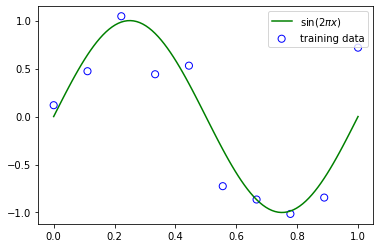

In [ ]:
# sin波にガウス分布に従ったノイズを加えたデータを作成
def create_toy_data(sin_curve, sample_size, std):
    # 訓練集合
    x = np.linspace(0, 1, sample_size)
    t = sin_curve(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

# sin波
def sin_curve(x):
    return np.sin(2 * np.pi * x)

# データ作成
x_train, y_train = create_toy_data(sin_curve, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sin_curve(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

#### 多項式を使用したデータへのフィッティング
以下のような多項式を使用してデータへのフィッティングを行う  
$$
y(x, \boldsymbol{w}) = w_{0} + w_{1}x + w_{2}x^{2} + ・・・+w_{M}x^{M} = \sum_{j=0}^Mw_{j}x^{j} \tag{1.1}
$$
ただし、Mは多項式の__次数（order）__を表す  
多項式 y(x, __w__) はxの非線形関数であるが、係数 __w__ の線形関数である  
未知のパラメータに関して線形であるような関数を__線形モデル（linear model）__という

#### 誤差関数
訓練データに多項式をあてはめることで係数の値を求める  
これは __w__ を任意に固定した時の関数 y(x, __w__) の値と訓練集合のデータ点との間のずれを測る__誤差関数（error function）__の最小化で達成できる  
誤差関数の選び方として、単純で広く用いられているものは__二乗和誤差（sum-squares error）__である  
以下のような式となり
$$
E(\boldsymbol{w}) = \frac{1}{2}\sum_{n=1}^{N} \{y(x_{n}, \boldsymbol{w}) - t_{n}\}^{2} \tag{1.2}
$$
これを最小化することが目標となる  
係数1/2については後の計算を楽にするために掛けてある  
ここでは、この式が非負であり0になるのはy(x,__w__)が全訓練データ点をちょうど通る時のみであることを注意しておく


#### モデル比較・モデル選択
E(__w__)をできるだけ小さくするような __w__ を選ぶことで曲線あてはめの問題を解くことができる  
誤差関数は __w__ の２次関数なので、その係数に関する微分は __w__ の要素に関して線形になり、通常、誤差関数を最小にするただ１つの解を持つ  
その解 __w*__ は閉じた形で決まり、結果として得られる多項式は y(x, __w*__) となる  
あとは多項式の次数Mを選ぶ問題が残っているが、この問題は__モデル比較（model comparison）__または__モデル選択（mdoel selection）__と呼ぶ  
ここではM=0, 1, 3, および9で多項式をあてはめてみる

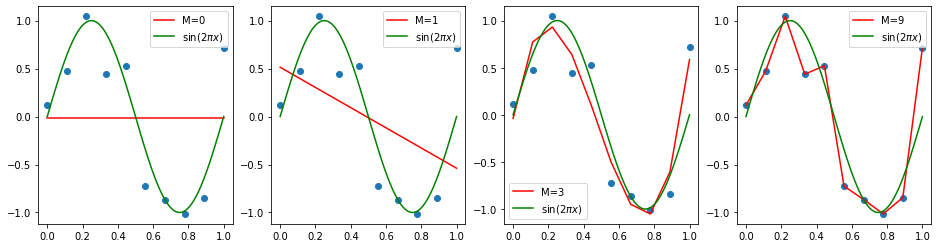

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for degree, ax in zip([0, 1, 3, 9], axes):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x_train.reshape(-1, 1))
    lin_reg = LinearRegression().fit(x_poly, y_train)
    x_line_poly = poly.fit_transform(x_train.reshape(-1, 1))
    ax.plot(x_train, lin_reg.predict(x_line_poly), c="r", label=f"M={degree}")
    ax.scatter(x_train, y_train)
    ax.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    ax.legend()

#### 過学習
定数の場合（M=０）と１次の場合（M=1）においてはデータへのあてはまりが良く無いことがわかる  
３次の場合（M=３）の場合が$\sin(2\pi x)$に最もよくあてはまっているように見える  
次数が高いものにした場合（M=9）には訓練データに対して非常に良くあてはまっているのがわかる  
実際、この多項式は全データを完全に通っており E(__w*__) = 0 となっている  
しかし、あてはめた曲線は無茶苦茶に発振したようになっており、関数$\sin(2\pi x)$の表現としては明らかに不適切となる  
このような振る舞いは__過学習（over fitting）__として知られている  
最終的な目標は新たなデータに対して正確な予測を行える高い汎化性能を得ることである  
そこで汎化性能がMにどう依存するのかを定量的に評価することにする  

#### 平均二乗平方誤差
100個のデータ点からなる独立したテスト集合を、訓練集合と全く同じやり方で生成する  
ただしランダムなノイズの値は新しく選ぶものとする  
選んだMの各値について、訓練データに対して（1.2）で与えられるE(__w*__)の残差が計算できるがテスト集合についても E(__w*__) を評価できる  
このとき、
$
E_{RMS} = \sqrt{\frac{2E(\boldsymbol{w^{*}})}{N}} \tag{1.3}
$
で定義される平均二乗平方誤差（root-mean-square error, RMS error）を用いると便利なことがある  
Nで割ることによってサイズの異なるデータ集合を比較することができるようになり  
平方根を取ることによって$E_{RMS}$は目的変数tと同じ尺度（単位）であることが保証される


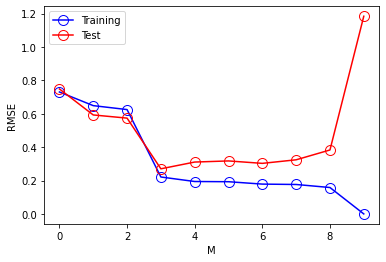

In [ ]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

training_errors = []
test_errors = []
# 回帰係数
coefficients = []

for M in range(0, 10):
    poly = PolynomialFeatures(degree=M)
    x_poly = poly.fit_transform(x_train.reshape(-1, 1))
    lin_reg = LinearRegression().fit(x_poly, y_train)
    x_train_line_poly = poly.fit_transform(x_train.reshape(-1, 1))
    x_test_line_poly = poly.fit_transform(x_test.reshape(-1, 1))
    training_errors.append(rmse(lin_reg.predict(x_train_line_poly), y_train))
    test_errors.append(rmse(lin_reg.predict(x_test_line_poly), y_test + np.random.normal(scale=0.25, size=len(y_test))))
    coefficients.append(lin_reg.coef_.tolist())
plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("M")
plt.ylabel("RMSE")
plt.show()

Mが小さい時はテスト集合の誤差が大きく対応する多項式は関数$\sin(2\pi x)$の振動を捉えることができていないことを意味している  
Mが $3 \leq M\leq8$の間ではテスト集合の誤差は小さく、M=３の場合で見たように$\sin(2\pi x)$を生成する妥当な表現といえる  
M=9では訓練集合の誤差は０となる、なぜなら10個の係数$w_0, w_1, ・・・w_{10}$に対応して多項式の自由度が10となり  
訓練集合の10個のデータ点にちょうどあてはまるからである  
関数 $\sin(2\pi x)$の級数展開はすべての次数の項を含むことが知られているのでMを増やすことで単調に良い結果が得られると期待できる  
そこで色々な次数の多項式について得られた係数 __w*__ を見てみる  
Mの値が大きくなるにつれて係数の多くが大きな値をとるようになることがわかる  
Mが大きく自由度の高い多項式は目的値のランダムノイズに引きずられてしまうと思えばよい

In [ ]:
for M, w in enumerate(coefficients):
    print(f'M={M}')
    print(w)

M=0
[0.0]
M=1
[0.0, -1.0524843940184905]
M=2
[0.0, -2.9841306444299445, 1.931646250411454]
M=3
[0.0, 10.820107102632651, -34.45045540399432, 24.25473443627052]
M=4
[0.0, 6.5884574678454095, -13.080624748318462, -10.021627605506813, 17.138181020888734]
M=5
[0.0, 5.2415738975381965, -1.8535148558705452, -41.75692490149294, 53.51401707242024, -14.550334420612721]
M=6
[0.0, -1.9476064796714414, 86.84133107948837, -423.50785846451714, 791.2384899707487, -670.7691417607953, 218.73960244672892]
M=7
[0.0, 3.150781584053175, 2.713937519600861, 75.37719590427776, -619.3894439744882, 1386.3375237211726, -1274.1158894571538, 426.53014054397113]
M=8
[0.0, -29.844249126567252, 668.105992884976, -4943.3953079348275, 18313.652546516932, -38030.43624886178, 44712.12017856899, -27728.30826845829, 7038.709602251993]
M=9
[0.0, -266.6870792236677, 6138.762765595352, -54219.61261787809, 249806.7522041453, -668703.6250841423, 1077401.2745807136, -1029372.6458546964, 536981.4297057815, -117765.0489119047]


#### 過学習の抑制（データ集合のサイズを変更）
モデルの次数を固定し、データ集合のサイズを変えてみたときの振る舞いを示す  
モデル複雑さを固定したとき、データ集合のサイズが大きくなるにつれて過学習の問題は深刻ではなくなっているのがわかる  
別の言い方をすると、データ集合のサイズが大きくなるほど、より複雑で柔軟なモデルをデータにあてはめられる  
大雑把な経験則としてデータの数はモデル中の適応パラメータの数の何倍（例えば５、１０）かよりは小さくてはいけないと言われている
しかし、必ずしもパラメータの数がモデルの複雑さを測る最適な尺度というわけではない  
また、入手できる訓練集合のサイズによってモデルのパラメータ数を制限するのは納得できない気もする  
モデルの複雑さは解くべき問題の複雑さに応じて選ぶのがもっともに思える  
最小二乗でモデルのパラメータを求めるアプローチが__最尤推定（maximum likelihood）__の特別な場合に相当し  
過学習の問題が最尤推定の持つ一般的性質として近いできることを後に示す

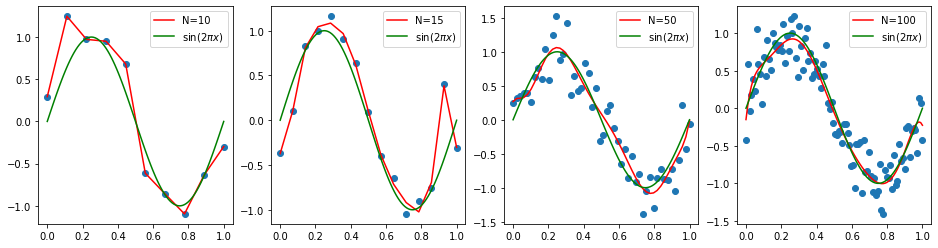

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for N, ax in zip([10, 15, 50, 100], axes):
    x_N_train, y_N_train = create_toy_data(sin_curve, N, 0.25)
    poly = PolynomialFeatures(degree=9)
    x_poly = poly.fit_transform(x_N_train.reshape(-1, 1))
    lin_reg = LinearRegression().fit(x_poly, y_N_train)
    x_line_poly = poly.fit_transform(x_N_train.reshape(-1, 1))
    ax.plot(x_N_train, lin_reg.predict(x_line_poly), c="r", label=f"N={N}")
    ax.scatter(x_N_train, y_N_train)
    ax.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
    ax.legend()

#### 過学習の抑制（正則化）
過学習を抑制するためのよく使われるテクニックに__正則化（regularization）__がある  
これは誤差関数（1.2）に罰金（penalty）項を付加することによって係数が大きな値をとることを防ごうとするものである  
そのような罰金項うち最も単純な物は係数を２乗して和をとったもので、誤差関数は以下のようになる  
$
\tilde{E}(\boldsymbol{w}) = \frac{1}{2}\sum_{n=1}^{N} \{y(x_{n}, \boldsymbol{w}) - t_{n}\}^{2} + \frac{\lambda}{2}\|\boldsymbol{w}\|^{2}\tag{1.4}
$
ここで
$
\|\boldsymbol{w}\|^{2}=\boldsymbol{w}^{\mathrm{T}}\boldsymbol{w}=w_0^2+w_1^2+・・・+w_M^2
$
であり、係数${\lambda}$は正則化項と二乗誤差の和の項との相対的な重要度を調整している  
ただし、係数$w_0$は正則化から外すことも多いので注意  
$w_0$は目的変数の原点の選び方に依存しているからで、正則化に入れるとしてもそれ専用の正則化係数を掛けたりする  
この場合も誤差関数（1.4）を最小にする解は完全に閉じた形で求まる  
このようなテクニックは統計学の分野で　__縮小推定（shrinkage）__と呼ばれている  
係数の値を小さくするというのがその理由である  
特に２次の正則化の場合は__リッジ回帰（ridge regression）__と呼ばれる  
またニューラルネットワークの文脈では__荷重減衰（weight decay）__として知られている  


## 1.2 確率論

### 1.2.1 確率密度

### 1.2.2 期待値と分散

### 1.2.3 ベイズ確率

### 1.2.4 ガウス分布

### 1.2.5 曲線フィッティング再訪

### 1.2.6 ベイズ曲線フィッティング

## 1.3 モデル選択

## 1.4 次元の呪い

## 1.5 決定理論

### 1.5.1 誤識別率の最小化

### 1.5.2 期待損失の最小化


### 1.5.3 棄却オプション

### 1.5.4 推論と決定

### 1.5.5 回帰のための損失関数

## 1.6 情報理論

### 1.6.1 相対エントロピーと相互情報量